In [53]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from evaluation_functions import ensemble_evaluation_functions as eef
import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
from calibration_functions import huxt_rank_functions as hrf

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number
import astropy.units as u

from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import time

In [2]:
cr = 1900
MAS_vr_map, MAS_vr_longs, MAS_vr_lats = Hin.get_MAS_vr_map(cr = cr)

VR_INT = hrf.interpolate_vmap(velocity_map=MAS_vr_map.value, lats=MAS_vr_lats, longs=MAS_vr_longs)

forecast_window = 5*u.day
E_lat = hrf.get_earth_lat(forecast_window, cr=cr, cr_lon_init=360*u.deg) # Get Earth latitude for sub earth paths

# HUXt model parameters (MAS)
dt_scale = 4
r_min = 30*u.solRad
forecast_window = 27*u.day

# Getting MAS map bits for interpolation and sub earth paths
MAS_vr_map, MAS_vr_longs, MAS_vr_lats = Hin.get_MAS_vr_map(cr = cr)
interpolated_MAS_vmap = hrf.interpolate_vmap(MAS_vr_map.value, MAS_vr_lats.value, MAS_vr_longs.value)

tilt = 15
perturbed_path = hrf.perturb_path(E_lat, tilt, MAS_vr_longs, 0, 1) # Random amplitude and phase, Fixed wave number

# Generate perturbed velocity boundary
velocity_boundary = hrf.extract_interpolated_velocity_boundary(interpolated_MAS_vmap, perturbed_path, MAS_vr_longs.to(u.deg))

Files already exist for CR1900
Files already exist for CR1900


In [55]:
def generate_perturbed_sub_earth_path(lat_earth, phase_phi, longitudes_theta, no_members, max_lat_dev):
    rng = np.random.default_rng(444)

    wave_numbers = np.ones(no_members)
    phase_offsets = rng.normal(loc = phase_phi, scale = 60, size = no_members)
    lat_deviations = rng.normal(loc = lat_earth, scale = max_lat_dev, size = no_members)

    perturbed_sub_earth_path = []
    
    for lat_dev, wave_no, phase_off in zip(lat_deviations, wave_numbers, phase_offsets):

        perturbed_sub_earth_path.append(lat_earth + lat_dev*np.sin(wave_no*(longitudes_theta) + phase_off) + np.pi/2)

    return perturbed_sub_earth_path*u.rad

def extract_interpolated_velocity_boundary(interpolated_map_solution, sub_earth_path, longitudes):
    # Function takes in a 2D interpolated MAS map and extracts wind speeds along given sub earth path across given longitudes

    velocity_boundary = interpolated_map_solution(sub_earth_path, longitudes)

    return velocity_boundary[0:-1]

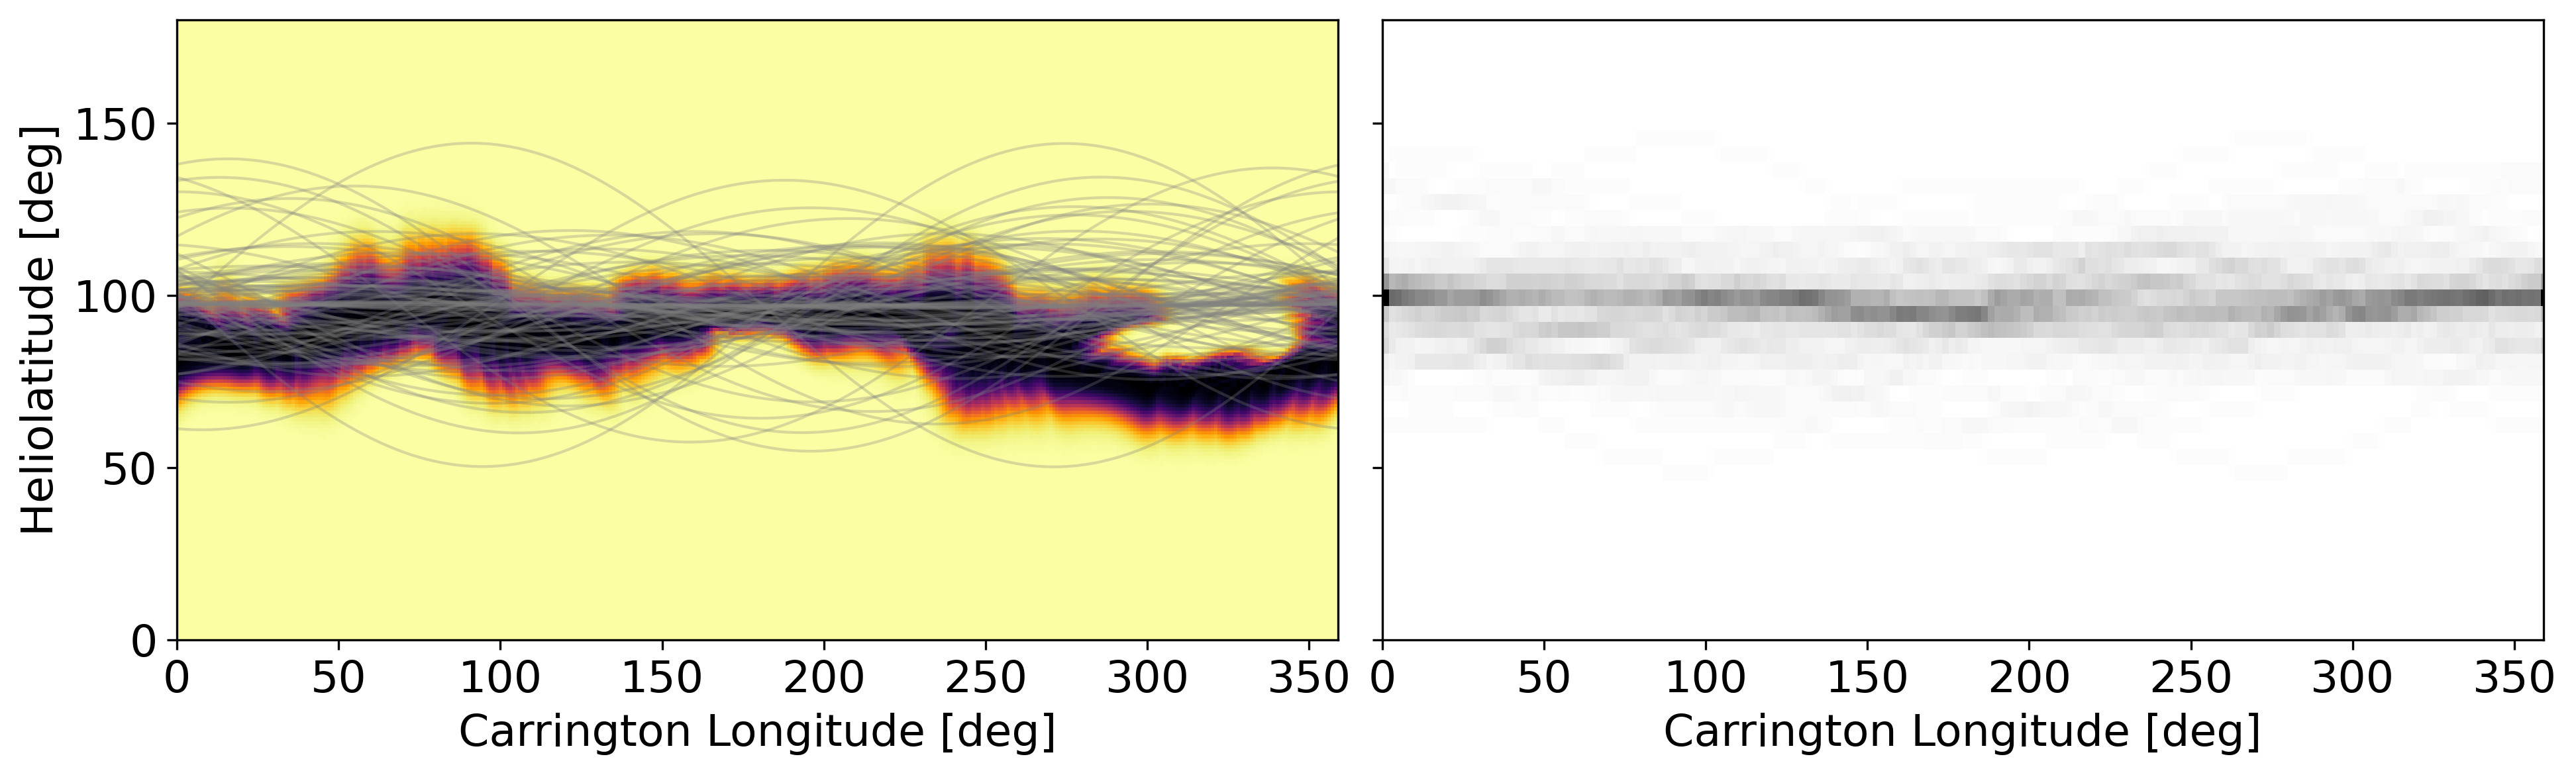

In [4]:
sigma_lat = np.radians(20)
sub_earth_path_pert = generate_perturbed_sub_earth_path(E_lat.value, 2*np.pi, MAS_vr_longs.value, 100, sigma_lat)

waves = []
for wave in sub_earth_path_pert:
    waves.append((MAS_vr_longs.to(u.deg).value, np.degrees(wave).value))

# Define bins for histogram
x_bins = np.linspace(0, 360, 180)  
y_bins = np.linspace(0, 180, 40)  

# Create empty 2D histogram
hist = np.zeros((len(x_bins) - 1, len(y_bins) - 1))

# Calculate histogram
for x, y in waves:
    hist_tmp, _, _ = np.histogram2d(x, y, bins=(x_bins, y_bins))
    hist += hist_tmp

# Plotting
fig,axes = plt.subplots(nrows = 1, ncols =2, dpi = 300, figsize = (13,4), sharey = True)
axes[0].imshow(MAS_vr_map.value, origin = 'lower', cmap = 'inferno', aspect='auto')
[axes[0].plot(MAS_vr_longs.to(u.deg).value, np.degrees(path), color = 'grey', alpha = 0.3, lw = 1) for path in sub_earth_path_pert]

axes[1].imshow(hist.T, extent=[x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()],origin='lower', aspect='auto', cmap='Greys')
axes[1].set_xlim(0,359)
axes[1].set_ylim(0,180)

axes[0].set_xlim(0,359)
axes[0].set_ylim(0,180)

axes[0].set_xlabel('Carrington Longitude [deg]')
axes[1].set_xlabel('Carrington Longitude [deg]')
axes[0].set_ylabel('Heliolatitude [deg]')

plt.tight_layout()

plt.show()

In [56]:
def gen_ensemble_perturbed_boundary_path(E_lat, longitudes, ensemble_size, sigma_latitude, random_seed):
    """
    creates an ensemble of perturbed sub earth paths,
    perturbation is a sinusoidal perturbation in latitude equivalent to rotation of coronal model source.

    Args:
        E_lat (float) : Earth's heliolatitude in radians
        longitudes (array) : longitudinal coords along boundary in radians
        ensemble_size (int) : number of ensemble members 
        sigma_latitude (float) : scale parameter which controls spread of perturbed inner-boundaries in radians
        random_seed (int) : random seed for perturbation generation
    Returns: 
    """

    rng = np.random.default_rng(random_seed) # initialise random number generator

    wave_numbers = np.ones(ensemble_size) # wavenumber set to 1
    phase_offsets = rng.uniform(0, 2*np.pi, size = ensemble_size) # phase set from uniform random distribution
    lat_deviations = rng.normal(loc = E_lat, scale = sigma_latitude, size = ensemble_size) # max deviation sourced from gaussian with sigma_lat width

    # Generate ensemble of paths
    perturbed_paths = []
    for theta_max, wave_no, phase_off in zip(lat_deviations, wave_numbers, phase_offsets):

        perturbed_paths.append(E_lat + theta_max * np.sin(wave_no * (longitudes) + phase_off))

    return perturbed_paths * u.rad

def interpolate_vmap(velocity_map, lats, longs):
    """
    Generates an interpolated solution of velocity map ready for sub-earth path extraction

    Args:
        velocity_map (2D array) : coronal model velocity map, shape (n x m)
        lats (array) : latitudinal coords along inner boundary, array of size n
        longs (array) : longitudinal coords along inner boundary, array of size m
    Returns:
        Int_2D_solution (object) : interpolation solution object
    """
    # Generate coordinate grid using n x m defined by length of lats and longs array
    #lat, long = np.mgrid[:len(lats), :len(longs)]

    long, lat = np.meshgrid(longs, lats)

    # This is an array with the shape 2,X --> formatted coordinate grid for interpolation
    X2D = np.array([long.flatten(), lat.flatten()]).T  

    # Run interpolation on velocity map
    Int_2D_solution = scipy.interpolate.LinearNDInterpolator(X2D, velocity_map.flatten())

    return Int_2D_solution

def extract_interpolated_velocity_boundary(interpolated_map_solution, boundary, longitudes):
    """
    generates velocity profile across longitudes along perturbed boundary from an interpolated coronal model solution

    Args:
        interpolated_map_solution (object) : interpolation solution object
        boundary (array) : perturbed latitudinal coordinates along inner boundary
        longitudes (array) : longitudinal coords along inner boundary
        
    Returns:
        velocity_boundary (array) : interpolated velocities across longitude (along the inner boundary)
    """

    velocity_boundary = interpolated_map_solution(longitudes, boundary)

    return velocity_boundary

def generate_ensemble_statistics(ensemble_members):
    """
    computes ensemble statistics which characterise the ensemble spread per timestep. 
     - range (min/max)
     - ensemble median/mean
     - 1 sigma spread (upper/lower)
     - 2 sigma spread (upper/lower)

    Args:
        ensemble_members (list) : list of dataFrames timeseries from HUXt model runs
    
    Returns:
        statistics_df (dataFrame) : timeseries of relevant ensemble statistics in each column
    """
    
    # Concatenate dataframes
    combined_df = pd.concat(ensemble_members, axis=0)

    # Group by time 
    grouped_df = combined_df.groupby('datetime')['vsw']

    # Compute statistics
    min_values = grouped_df.min()
    max_values = grouped_df.max()
    median_values = grouped_df.median()
    mean_values = grouped_df.mean()
    lower_2s_percentile = grouped_df.quantile(0.14)
    upper_2s_percentile = grouped_df.quantile(0.86)
    lower_1s_percentile = grouped_df.quantile(0.34)
    upper_1s_percentile = grouped_df.quantile(0.68)

    # Combine statistics into a single dataframe
    statistics_df = pd.DataFrame({
        'min': min_values,
        'max': max_values,
        'median' : median_values,
        'mean' : mean_values,
        '1s_lower_percentile': lower_1s_percentile,
        '1s_upper_percentile': upper_1s_percentile,
        '2s_lower_percentile': lower_2s_percentile,
        '2s_upper_percentile': upper_2s_percentile
    })

    return statistics_df

In [58]:
cr = 2235
ensemble_size = 1
sigma_latitude = 10
random_seed = 10

# HUXt model parameters (MAS)
dt_scale = 4
r_min = 30*u.solRad
forecast_window = 27*u.day
forecast_window = 1 * u.day

Hin.get_MAS_boundary_conditions(cr=2235, observatory='', runtype='', runnumber='', masres='medium')

MAS_vr_map_med, MAS_vr_longs, MAS_vr_lats = Hin.get_MAS_vr_map(cr = cr)
INT_med = interpolate_vmap(MAS_vr_map_med.value, MAS_vr_lats.value, MAS_vr_longs.value)

# Use the HUXt ephemeris data to get Earth lat over the CR
dummymodel = H.HUXt(v_boundary=np.ones(128)*400*(u.km/u.s), simtime=forecast_window, dt_scale=dt_scale, cr_num=cr,
                    cr_lon_init=0.0*u.deg, lon_out=0.0*u.deg)

# Retrieve a bodies position at each model timestep:
earth = dummymodel.get_observer('earth')

# Get average Earth lat
E_lat = np.nanmean(earth.lat_c)

# Generate perturbed inner boundary paths
perturbed_boundary_paths = gen_ensemble_perturbed_boundary_path(E_lat = E_lat.value, longitudes=MAS_vr_longs.value, 
                                                        ensemble_size = ensemble_size, sigma_latitude = np.radians(sigma_latitude), random_seed = random_seed)

# Generate ensemble of interpolated near-sun velocity boundaries
velocity_boundaries = [extract_interpolated_velocity_boundary(interpolated_map_solution=INT_med, boundary=boundary.value, longitudes=MAS_vr_longs.value) 
                    for boundary in perturbed_boundary_paths]

# Initialise ensemble member list
ensemble_members_med = []

for v_boundary in velocity_boundaries:

    t1 = time.time()
    # set up and run HUXt model. 
    model = H.HUXt(v_boundary=v_boundary*(u.km/u.s), cr_num=cr, cr_lon_init=0*u.deg, simtime=forecast_window, dt_scale=4, r_min = r_min)
    model.solve([])

    t2 = time.time()
    print(t2-t1)

    # Extract Earth time series dataFrame
    df_earth_series = HA.get_observer_timeseries(model, observer = 'Earth')
    df_earth_series = df_earth_series.rename(columns = {'time':'datetime'}) # rename time column to match OMNI dataframe format (for ease later on)
    df_earth_series['datetime'] = df_earth_series['datetime'].values.astype(dtype='datetime64[ns]') # setting index to datetime ready for longitudinal perturbation
    df_earth_series = df_earth_series.set_index('datetime')
    ensemble_members_med.append(df_earth_series.copy())


Files already exist for CR2235
0.9502160549163818


In [21]:
cr = 2235
ensemble_size = 100
sigma_latitude = 10
random_seed = 10

# HUXt model parameters (MAS)
dt_scale = 4
r_min = 30*u.solRad
forecast_window = 27*u.day

Hin.get_MAS_boundary_conditions(cr=2235, observatory='', runtype='', runnumber='', masres='high')

MAS_vr_map_high, MAS_vr_longs, MAS_vr_lats = Hin.get_MAS_vr_map(cr = cr)
INT_high = interpolate_vmap(MAS_vr_map.value, MAS_vr_lats.value, MAS_vr_longs.value)

# Use the HUXt ephemeris data to get Earth lat over the CR
dummymodel = H.HUXt(v_boundary=np.ones(128)*400*(u.km/u.s), simtime=forecast_window, dt_scale=dt_scale, cr_num=cr,
                    cr_lon_init=0.0*u.deg, lon_out=0.0*u.deg)

# Retrieve a bodies position at each model timestep:
earth = dummymodel.get_observer('earth')

# Get average Earth lat
E_lat = np.nanmean(earth.lat_c)

# Generate perturbed inner boundary paths
perturbed_boundary_paths = gen_ensemble_perturbed_boundary_path(E_lat = E_lat.value, longitudes=MAS_vr_longs.value, 
                                                        ensemble_size = ensemble_size, sigma_latitude = np.radians(sigma_latitude), random_seed = random_seed)

# Generate ensemble of interpolated near-sun velocity boundaries
velocity_boundaries = [extract_interpolated_velocity_boundary(interpolated_map_solution=INT_high, boundary=boundary.value, longitudes=MAS_vr_longs.value) 
                    for boundary in perturbed_boundary_paths]

# Initialise ensemble member list
ensemble_members_high = []

for v_boundary in velocity_boundaries:

    # set up and run HUXt model. 
    model = H.HUXt(v_boundary=v_boundary*(u.km/u.s), cr_num=cr, cr_lon_init=0*u.deg, simtime=forecast_window, dt_scale=4, r_min = r_min)
    model.solve([])

    # Extract Earth time series dataFrame
    df_earth_series = HA.get_observer_timeseries(model, observer = 'Earth')
    df_earth_series = df_earth_series.rename(columns = {'time':'datetime'}) # rename time column to match OMNI dataframe format (for ease later on)
    df_earth_series['datetime'] = df_earth_series['datetime'].values.astype(dtype='datetime64[ns]') # setting index to datetime ready for longitudinal perturbation
    df_earth_series = df_earth_series.set_index('datetime')
    ensemble_members_high.append(df_earth_series.copy())

Files already exist for CR2235


In [46]:
statistics_df_high.index[::250]

DatetimeIndex(['2020-10-05 00:14:02.926588672',
               '2020-10-11 01:10:17.926588672',
               '2020-10-17 02:06:32.926588672',
               '2020-10-23 03:02:47.926588672',
               '2020-10-29 03:59:02.926588672'],
              dtype='datetime64[ns]', name='datetime', freq=None)

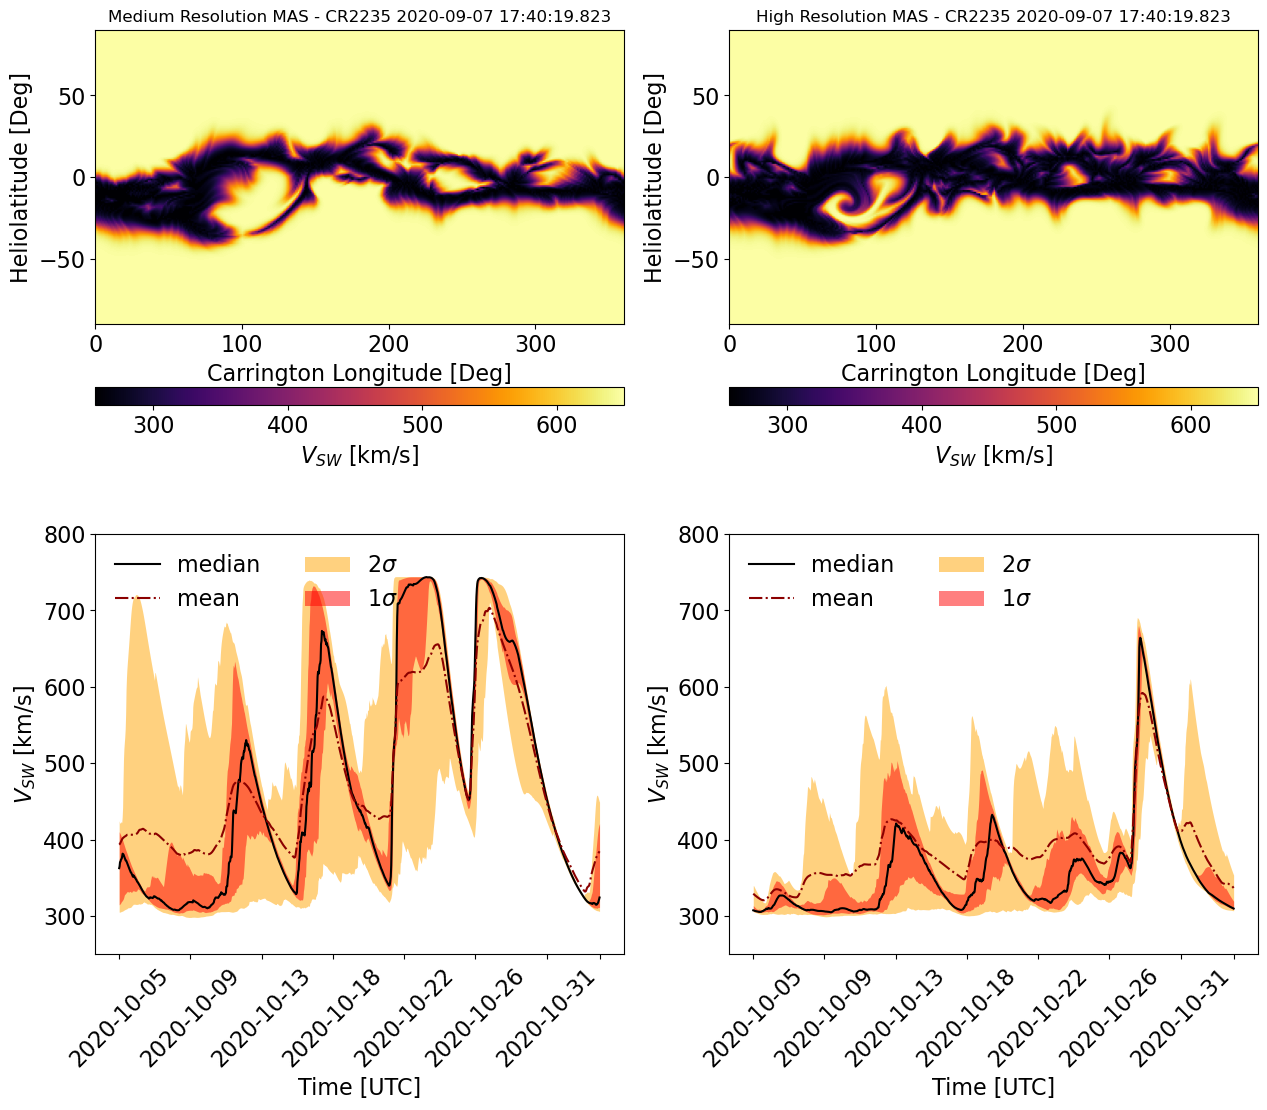

In [49]:
statistics_df_med = generate_ensemble_statistics(ensemble_members=ensemble_members_med)
statistics_df_high = generate_ensemble_statistics(ensemble_members=ensemble_members_high)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,12))

axes = axes.flatten()

im = axes[0].imshow(MAS_vr_map_med.value, extent = (0,360,-90,90), cmap = 'inferno', aspect = 'auto')
#for bd in perturbed_boundary_paths:
#    axes[0].plot(np.linspace(0,360, 360), bd.to(u.deg).value, color = 'cornflowerblue', lw = 1, alpha = 0.3)
fig.colorbar(im, ax = axes[0], label = r'$V_{SW}$ [km/s]', orientation = 'horizontal', aspect = 30)#, location = 'bottom')
axes[0].set_xlabel('Carrington Longitude [Deg]')
axes[0].set_ylabel(r'Heliolatitude [Deg]')
axes[0].set_title(f'Medium Resolution MAS - CR{cr} {carrington_rotation_time(cr)}')

axes[2].fill_between(statistics_df_med.index, statistics_df_med['2s_lower_percentile'], statistics_df_med['2s_upper_percentile'], label = r'2$\sigma$' , color = 'orange', alpha = 0.5, lw = 0)
axes[2].fill_between(statistics_df_med.index, statistics_df_med['1s_lower_percentile'], statistics_df_med['1s_upper_percentile'], label = r'1$\sigma$', color = 'red', alpha = 0.5, lw = 0)
axes[2].fill_between(statistics_df_med.index, statistics_df_med['min'], statistics_df_med['max'], facecolor = 'none', edgecolor = 'grey', linestyle = '--', label = 'max range' )
axes[2].plot(statistics_df_med.index, statistics_df_med['median'], color = 'black', label = 'median')
axes[2].plot(statistics_df_med.index, statistics_df_med['mean'], color = 'darkred', linestyle = '-.', label = 'mean')
#plt.lot(data_chunk['V'], color = 'purple', label = 'OMNI data')
axes[2].legend(frameon = False, loc = 'upper left', ncol = 2)
axes[2].set_xlabel('Time [UTC]')
axes[2].set_ylabel(r'$V_{SW}$ [km/s]')
axes[2].set_xticklabels([dt.strftime("%Y-%m-%d") for dt in statistics_df_high.index[::180]], rotation = 45)

axes[2].set_ylim(250,800)
#plt.xlim(data_chunk.index[0], data_chunk.index[-60])



im2 = axes[1].imshow(MAS_vr_map_high.value, extent = (0,360,-90,90), cmap = 'inferno', aspect = 'auto')
axes[1].set_title(f'High Resolution MAS - CR{cr} {carrington_rotation_time(cr)}')
#for bd in perturbed_boundary_paths:
#    axes[1].plot(np.linspace(0,360, 360), bd.to(u.deg).value, color = 'cornflowerblue', lw = 1, alpha = 0.3)
fig.colorbar(im2, ax = axes[1], label = r'$V_{SW}$ [km/s]', orientation = 'horizontal', aspect = 30)#, location = 'bottom')
axes[1].set_xlabel('Carrington Longitude [Deg]')
axes[1].set_ylabel(r'Heliolatitude [Deg]')

axes[3].fill_between(statistics_df_high.index, statistics_df_high['2s_lower_percentile'], statistics_df_high['2s_upper_percentile'], label = r'2$\sigma$' , color = 'orange', alpha = 0.5, lw = 0)
axes[3].fill_between(statistics_df_high.index, statistics_df_high['1s_lower_percentile'], statistics_df_high['1s_upper_percentile'], label = r'1$\sigma$', color = 'red', alpha = 0.5, lw = 0)
#axes[3].fill_between(statistics_df_high.index, statistics_df_high['min'], statistics_df_high['max'], facecolor = 'none', edgecolor = 'grey', linestyle = '--', label = 'max range' )
axes[3].plot(statistics_df_high.index, statistics_df_high['median'], color = 'black', label = 'median')
axes[3].plot(statistics_df_high.index, statistics_df_high['mean'], color = 'darkred', linestyle = '-.', label = 'mean')
#plt.plot(data_chunk['V'], color = 'purple', label = 'OMNI data')
axes[3].legend(frameon = False, loc = 'upper left', ncol = 2)
axes[3].set_xlabel('Time [UTC]')
axes[3].set_ylabel(r'$V_{SW}$ [km/s]')
axes[3].set_ylim(250,800)
axes[3].set_xticklabels([dt.strftime("%Y-%m-%d") for dt in statistics_df_high.index[::180]], rotation = 45)

#plt.ylim(300,900)
#plt.xlim(data_chunk.index[0], data_chunk.index[-60])
#plt.tight_layout()
plt.show()

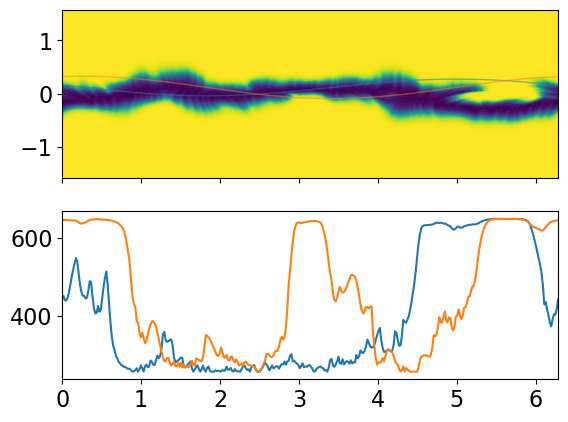

In [39]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True)
axes[0].imshow(MAS_vr_map.value, extent = (0, 2*np.pi, -np.pi/2, np.pi/2), aspect = 'auto', origin = 'lower')
for boundary in perturbed_boundary_paths:
    axes[0].plot(np.linspace(0,2*np.pi, 360), boundary, alpha = 0.5, lw = 1)
#axes[0].colorbar()


for i in range(ensemble_size):
    axes[1].plot(np.linspace(0,2*np.pi, 360), velocity_boundaries[i])

plt.show()

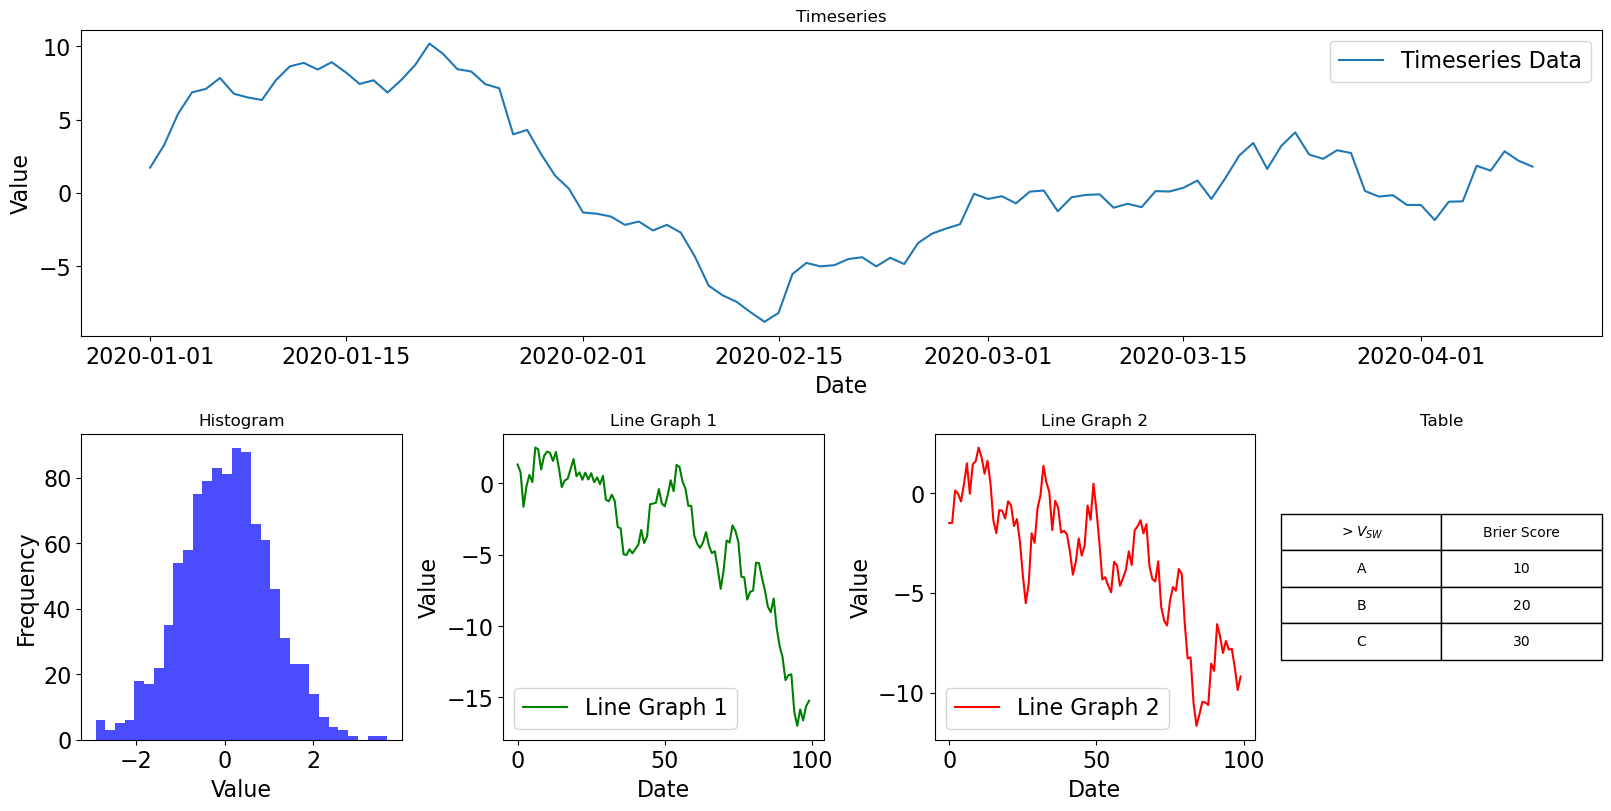

In [12]:
# Sample data
time = pd.date_range(start='1/1/2020', periods=100, freq='D')
data = np.random.randn(100).cumsum()
hist_data = np.random.randn(1000)
line_data1 = np.random.randn(100).cumsum()
line_data2 = np.random.randn(100).cumsum()

# Create figure and subplots
fig = plt.figure(constrained_layout=True, figsize=(16, 8))
gs = fig.add_gridspec(2, 4)

# Top row: Timeseries
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(time, data, label='Timeseries Data')
ax1.set_title('Timeseries')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')
ax1.legend()

# Bottom row: Histogram
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(hist_data, bins=30, alpha=0.7, color='blue')
ax2.set_title('Histogram')
ax2.set_xlabel('Value')
ax2.set_ylabel('Frequency')

# Bottom row: Line graph 1
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(line_data1, label='Line Graph 1', color='green')
ax3.set_title('Line Graph 1')
ax3.set_xlabel('Date')
ax3.set_ylabel('Value')
ax3.legend()

# Bottom row: Line graph 2
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(line_data2, label='Line Graph 2', color='red')
ax4.set_title('Line Graph 2')
ax4.set_xlabel('Date')
ax4.set_ylabel('Value')
ax4.legend()

# Bottom row: Table
ax5 = fig.add_subplot(gs[1, 3])
table_data = pd.DataFrame({
    r'$>V_{SW}$': ['A', 'B', 'C'],
    'Brier Score': [10, 20, 30, ]
})
ax5.axis('off')
table = ax5.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
table.scale(1, 2)
ax5.set_title('Table')

# Show plot
plt.show()

Files already exist for CR2239


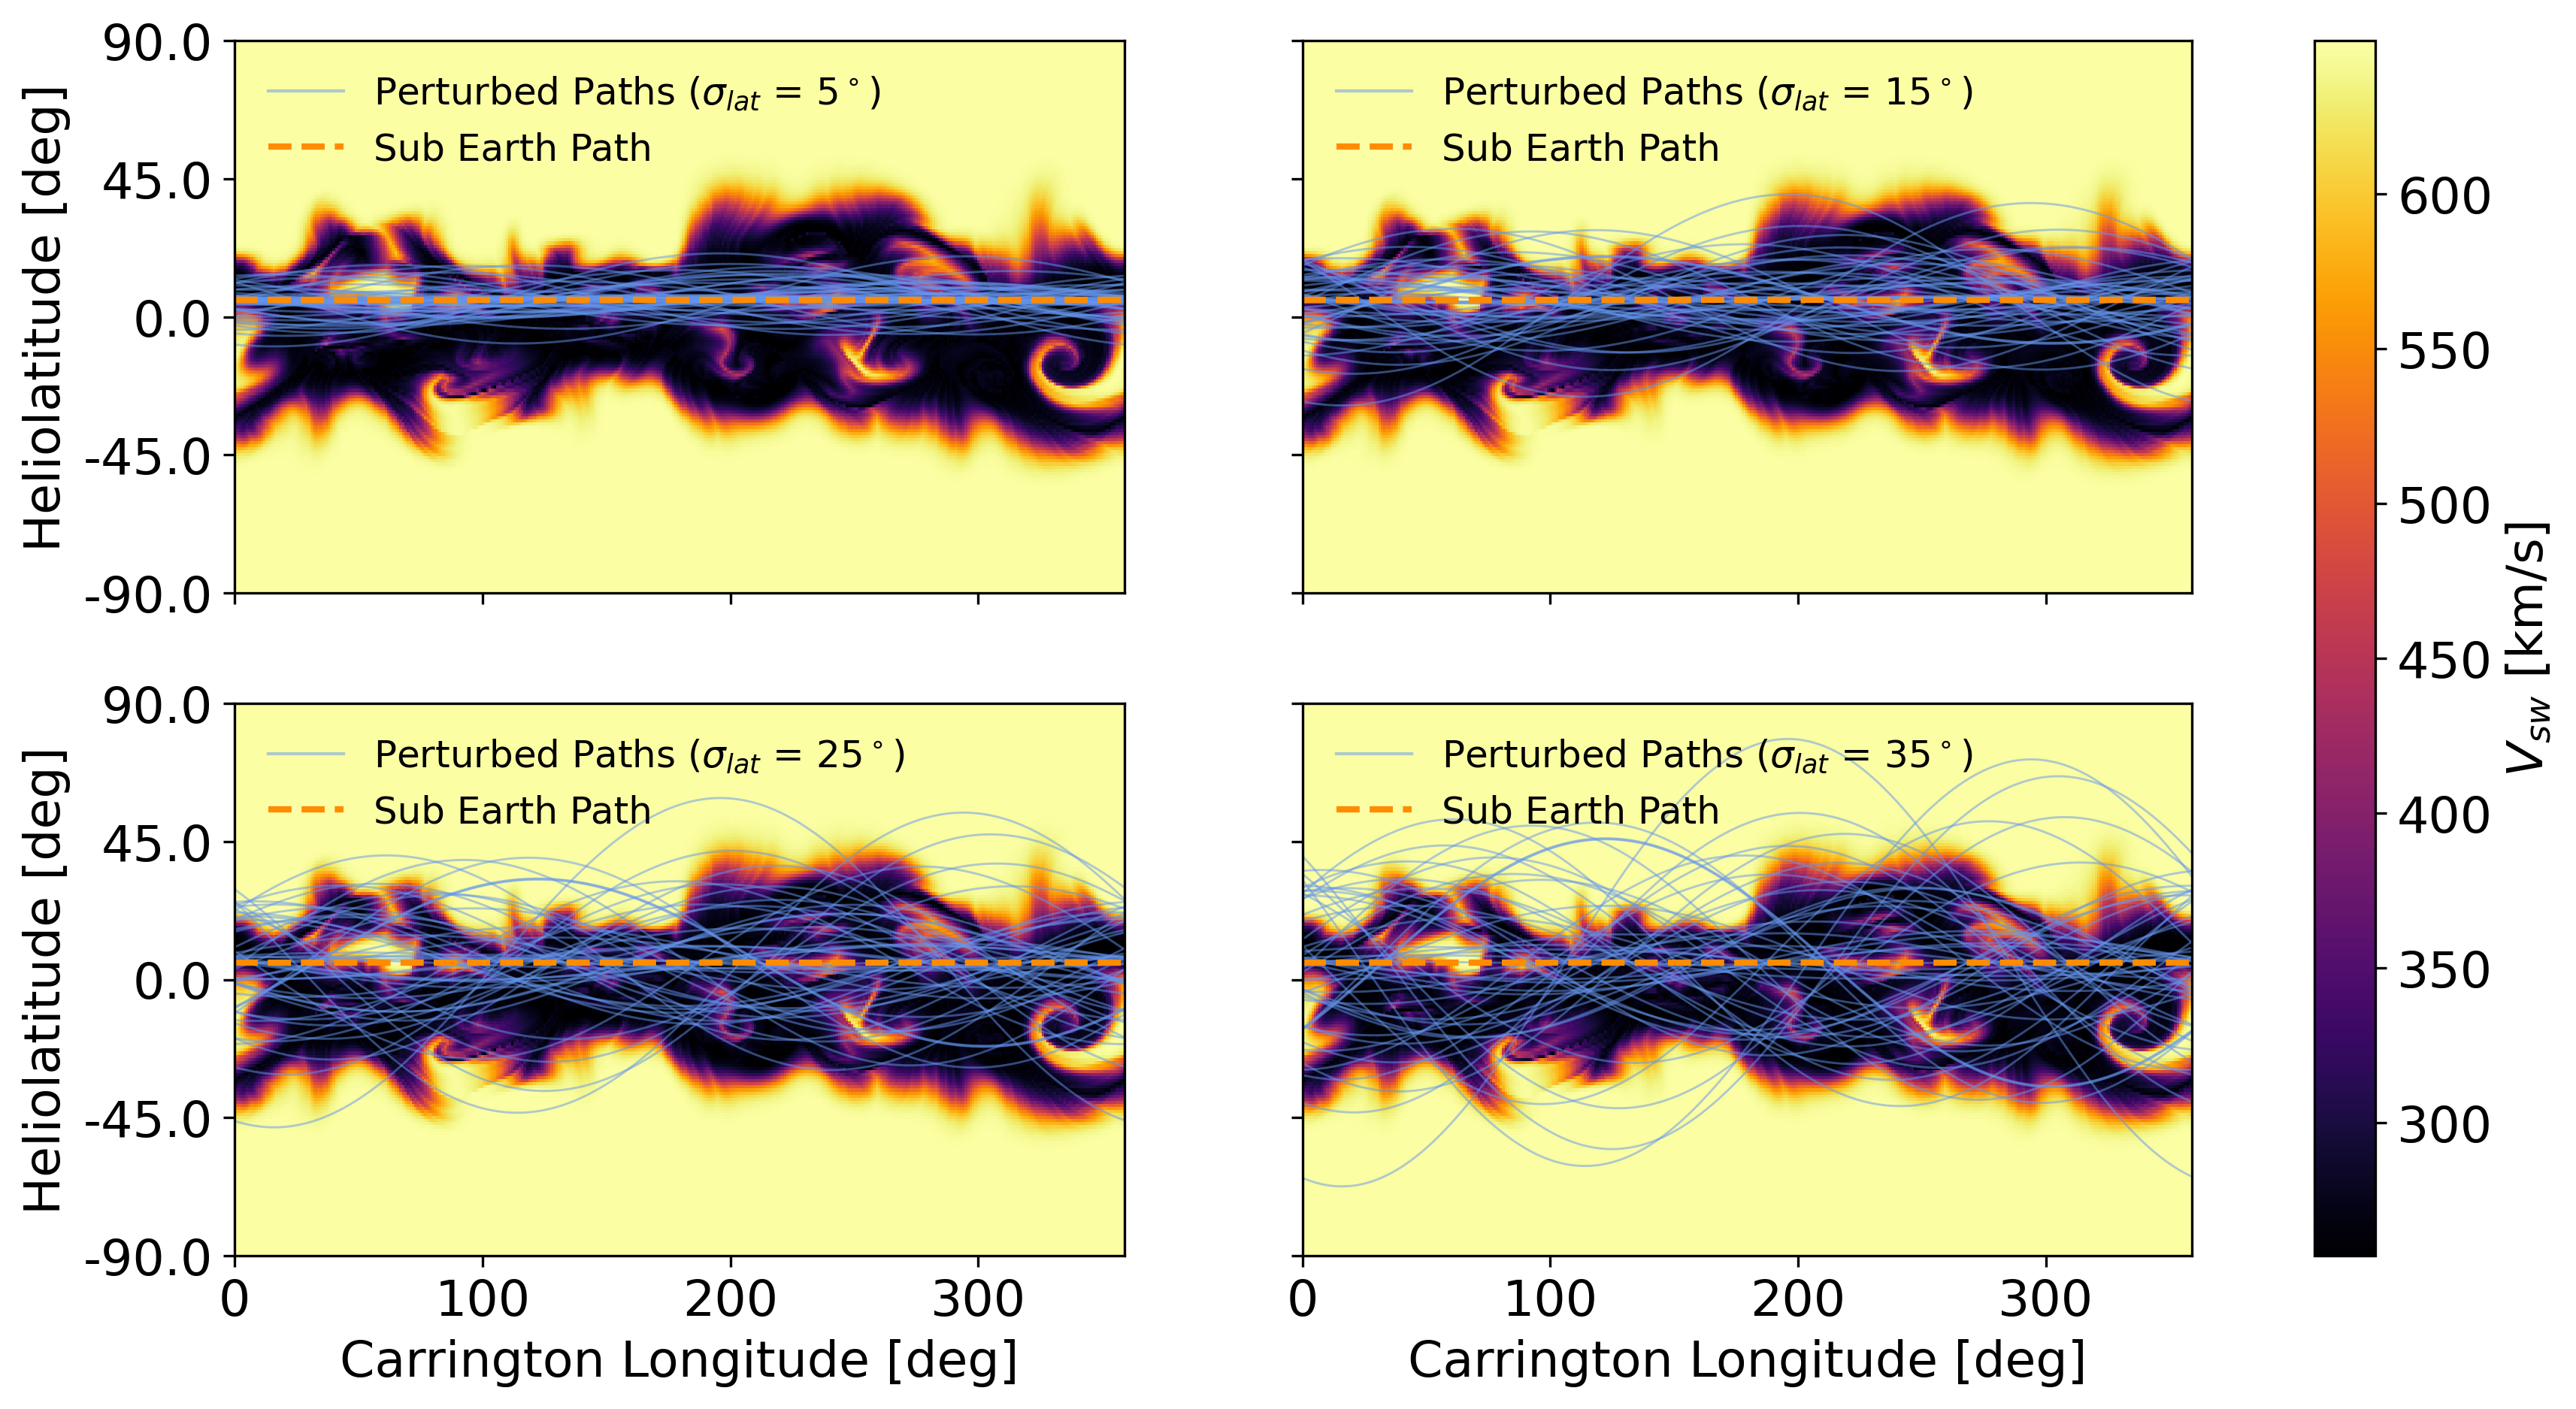

In [52]:
ensemble_size = 50

MAS_vr_map, MAS_vr_longs, MAS_vr_lats = Hin.get_MAS_vr_map(cr = 2239)

# Plotting
fig,axes = plt.subplots(nrows = 2, ncols =2, dpi = 300, figsize = (14,7), sharey = True, sharex = True)

axes = axes.flatten()


for i, sigma_lat in enumerate([5,15,25,35]):


    sub_earth_path_pert = generate_perturbed_sub_earth_path(E_lat.value, 2*np.pi, MAS_vr_longs.value, ensemble_size, np.radians(sigma_lat))

    im = axes[i].imshow(MAS_vr_map.value, origin = 'lower', cmap = 'inferno', aspect='auto')
    [axes[i].plot(MAS_vr_longs.to(u.deg).value, np.degrees(path), color = 'cornflowerblue', alpha = 0.5, lw = 0.7) for path in sub_earth_path_pert]
    axes[i].plot(MAS_vr_longs.to(u.deg).value, np.degrees(sub_earth_path_pert[0]), color = 'cornflowerblue', alpha = 0.5, lw = 1, 
                 label = f'Perturbed Paths ($\sigma_{{lat}}$ = {sigma_lat}$^\circ$)')
    axes[i].axhline(90+np.degrees(E_lat.value), color = 'darkorange', lw =2, label = 'Sub Earth Path', linestyle = '--')
    axes[i].legend(frameon = False, loc = 'upper left', fontsize = 'large')


axes[0].set_xlim(0,359)
axes[0].set_ylim(0,180)
axes[0].set_yticks(np.linspace(0,180,5))
axes[0].set_yticklabels(np.linspace(-90,90,5))
axes[2].set_yticks(np.linspace(0,180,5))
axes[2].set_yticklabels(np.linspace(-90,90,5))

axes[2].set_xlabel('Carrington Longitude [deg]')
axes[3].set_xlabel('Carrington Longitude [deg]')
axes[0].set_ylabel('Heliolatitude [deg]')
axes[2].set_ylabel('Heliolatitude [deg]')


# Create a single colorbar for all subplots
cbar1 = fig.colorbar(im, ax=axes, orientation = 'vertical', aspect = 20) #, anchor = (-2,-2), aspect = 30)  
cbar1.set_label(f'$V_{{sw}}$ [km/s]')

#plt.tight_layout()
fname = 'pertrubation_scheme_parameter_demo.pdf'
path = f'C:\\Users\\ct832900\\OneDrive - University of Reading\\Ensemble Calibration Paper\\Figures_revised\\{fname}'
plt.savefig(path, format = 'pdf', dpi = 300, bbox_inches='tight')

plt.show()